In [21]:
path_data = '../../data/'

import numpy as np
import pandas as pd
import math
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import folium
from folium.plugins import MarkerCluster, BeautifyIcon

import warnings
warnings.filterwarnings('ignore')

# Bike Sharing in the Bay Area

We end this chapter by using all the methods we have learned to examine a new and large dataset. We will also introduce the [`folium`](https://python-visualization.github.io/folium/) module, a powerful visualization tool.

The [Bay Area Bike Share](http://www.bayareabikeshare.com/) service published a [dataset](http://www.bayareabikeshare.com/open-data) describing every bicycle rental from September 2014 to August 2015 in their system. There were 354,152 rentals in all. The columns are:

- An ID for the rental
- Duration of the rental, in seconds
- Start date
- Name of the Start Station and code for Start Terminal
- Name of the End Station and code for End Terminal
- A serial number for the bike
- Subscriber type and zip code  

[Python Folium](https://python-visualization.github.io/folium/)

In [22]:
trips = pd.read_csv(path_data + 'trip.csv')
trips

Trip ID  Duration       Start Date  \
0        913460       765  8/31/2015 23:26   
1        913459      1036  8/31/2015 23:11   
2        913455       307  8/31/2015 23:13   
3        913454       409  8/31/2015 23:10   
4        913453       789  8/31/2015 23:09   
...         ...       ...              ...   
354147   432951       619    9/1/2014 4:21   
354148   432950      6712    9/1/2014 3:16   
354149   432949       538    9/1/2014 0:05   
354150   432948       568    9/1/2014 0:05   
354151   432947       569    9/1/2014 0:05   

                               Start Station  Start Terminal         End Date  \
0       Harry Bridges Plaza (Ferry Building)              50  8/31/2015 23:39   
1                San Antonio Shopping Center              31  8/31/2015 23:28   
2                             Post at Kearny              47  8/31/2015 23:18   
3                         San Jose City Hall              10  8/31/2015 23:17   
4                      Embarcadero at Folsom              51  8/31/2015 23:22   
...                                      ...             ...              ...   
354147                    Powell Street BART              39    9/1/2014 4:32   
354148  Harry Bridges Plaza (Ferry Building)              50    9/1/2014 5:08   
354149              South Van Ness at Market              66    9/1/2014 0:14   
354150              South Van Ness at Market              66    9/1/2014 0:15   
354151              South Van Ness at Market              66    9/1/2014 0:15   

                                     End Station  End Terminal  Bike #  \
0       San Francisco Caltrain (Townsend at 4th)            70     288   
1                        Mountain View City Hall            27      35   
2                              2nd at South Park            64     468   
3                            San Salvador at 1st             8      68   
4                         Embarcadero at Sansome            60     487   
...                                          ...           ...     ...   
354147                           Townsend at 7th            65     335   
354148  San Francisco Caltrain (Townsend at 4th)            70     259   
354149                             5th at Howard            57     466   
354150                             5th at Howard            57     461   
354151                             5th at Howard            57     318   

       Subscriber Type Zip Code  
0           Subscriber     2139  
1           Subscriber    95032  
2           Subscriber    94107  
3           Subscriber    95113  
4             Customer     9069  
...                ...      ...  
354147      Subscriber    94118  
354148        Customer    44100  
354149        Customer       32  
354150        Customer       32  
354151        Customer       32  

[354152 rows x 11 columns]

We'll focus only on the *free trips*, which are trips that last less than 1800 seconds (half an hour). There is a charge for longer trips.

The histogram below shows that most of the trips took around 10 minutes (600 seconds) or so. Very few took near 30 minutes (1800 seconds), possibly because people try to return the bikes before the cutoff time so as not to have to pay.

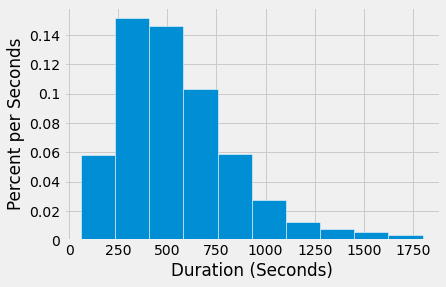

In [23]:
commute = trips[trips['Duration'] < 1800]

unit = 'Seconds'

fig, ax1 = plt.subplots()

ax1.hist(commute['Duration'], 10, density=True, ec='white')

y_vals = ax1.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Duration (' + (unit if unit else 'unit') + ')'

ax1.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.show()

We can get more detail by specifying a larger number of bins. But the overall shape doesn't change much.

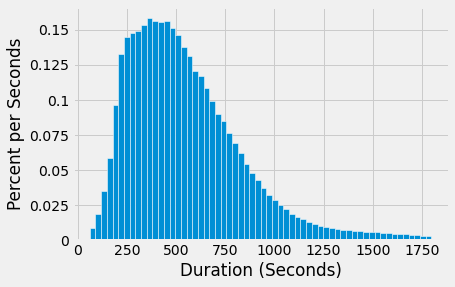

In [24]:
commute = trips[trips['Duration'] < 1800]

unit = 'Seconds'

fig, ax1 = plt.subplots()

ax1.hist(commute['Duration'], 60, density=True, ec='white')

y_vals = ax1.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'Duration (' + (unit if unit else 'unit') + ')'

ax1.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.show()

## Exploring the Data with `group` and `pivot`

We can use `group` to identify the most highly used Start Station:

In [25]:
starts = commute.groupby(["Start Station"]).agg(
    count=pd.NamedAgg(column="Start Station", aggfunc="count")
)

starts.sort_values('count', ascending=False)

count
Start Station                                       
San Francisco Caltrain (Townsend at 4th)       25858
San Francisco Caltrain 2 (330 Townsend)        21523
Harry Bridges Plaza (Ferry Building)           15543
Temporary Transbay Terminal (Howard at Beale)  14298
2nd at Townsend                                13674
...                                              ...
Mezes Park                                       189
Redwood City Medical Center                      139
San Mateo County Center                          108
Redwood City Public Library                      101
Franklin at Maple                                 62

[70 rows x 1 columns]

The largest number of trips started at the Caltrain Station on Townsend and 4th in San Francisco. People take the train into the city, and then use a shared bike to get to their next destination.

The `group` method can also be used to classify the rentals by both Start Station and End Station.

In [26]:
commute_groupby = commute.groupby(["Start Station", "End Station"]).agg(
    count=pd.NamedAgg(column="Start Station", aggfunc="count")
)

commute_groupby.sort_values(['Start Station', 'End Station'])

count
Start Station                                 End Station                                         
2nd at Folsom                                 2nd at Folsom                                     54
                                              2nd at South Park                                295
                                              2nd at Townsend                                  437
                                              5th at Howard                                    113
                                              Beale at Market                                  127
...                                                                                            ...
Yerba Buena Center of the Arts (3rd @ Howard) Steuart at Market                                202
                                              Temporary Transbay Terminal (Howard at Beale)    113
                                              Townsend at 7th                                  261
                                              Washington at Kearny                              66
                                              Yerba Buena Center of the Arts (3rd @ Howard)     73

[1629 rows x 1 columns]

In [27]:
#Or

commute_groupby = commute.groupby(["Start Station", "End Station"]).agg(
    count=pd.NamedAgg(column="Start Station", aggfunc="count")
)

commute_groupby.sort_values(['Start Station', 'End Station']).reset_index()

commute_groupby

count
Start Station                                 End Station                                         
2nd at Folsom                                 2nd at Folsom                                     54
                                              2nd at South Park                                295
                                              2nd at Townsend                                  437
                                              5th at Howard                                    113
                                              Beale at Market                                  127
...                                                                                            ...
Yerba Buena Center of the Arts (3rd @ Howard) Steuart at Market                                202
                                              Temporary Transbay Terminal (Howard at Beale)    113
                                              Townsend at 7th                                  261
                                              Washington at Kearny                              66
                                              Yerba Buena Center of the Arts (3rd @ Howard)     73

[1629 rows x 1 columns]

Fifty-four trips both started and ended at the station on 2nd at Folsom. A much large number (437) were between 2nd at Folsom and 2nd at Townsend. 

The `pivot` method does the same classification but displays its results in a contingency table that shows all possible combinations of Start and End Stations, even though some of them didn't correspond to any trips. Remember that the first argument of a `pivot` statement specifies the column labels of the pivot table; the second argument labels the rows.

There is a train station as well as a Bay Area Rapid Transit (BART) station near Beale at Market, explaining the high number of trips that start and end there.

In [28]:
commuteGroupby = commute_groupby.copy()

#Though 'Start Station' is displayed as a column it is actually an index.
#To enable use as a df column the index must be reset setting parameter 'inplace' = True

commuteGroupby.reset_index(inplace=True)

commuteGroupby.pivot(index='Start Station', columns='End Station', values='count').fillna(0)

End Station                                    2nd at Folsom  \
Start Station                                                  
2nd at Folsom                                           54.0   
2nd at South Park                                      190.0   
2nd at Townsend                                        554.0   
5th at Howard                                          107.0   
Adobe on Almaden                                         0.0   
...                                                      ...   
Temporary Transbay Terminal (Howard at Beale)          237.0   
Townsend at 7th                                        342.0   
University and Emerson                                   0.0   
Washington at Kearny                                    17.0   
Yerba Buena Center of the Arts (3rd @ Howard)           31.0   

End Station                                    2nd at South Park  \
Start Station                                                      
2nd at Folsom                                              295.0   
2nd at South Park                                          164.0   
2nd at Townsend                                             71.0   
5th at Howard                                              180.0   
Adobe on Almaden                                             0.0   
...                                                          ...   
Temporary Transbay Terminal (Howard at Beale)              429.0   
Townsend at 7th                                            143.0   
University and Emerson                                       0.0   
Washington at Kearny                                        63.0   
Yerba Buena Center of the Arts (3rd @ Howard)              209.0   

End Station                                    2nd at Townsend  5th at Howard  \
Start Station                                                                   
2nd at Folsom                                            437.0          113.0   
2nd at South Park                                        151.0          177.0   
2nd at Townsend                                          185.0          148.0   
5th at Howard                                             92.0           83.0   
Adobe on Almaden                                           0.0            0.0   
...                                                        ...            ...   
Temporary Transbay Terminal (Howard at Beale)            784.0          750.0   
Townsend at 7th                                          417.0          200.0   
University and Emerson                                     0.0            0.0   
Washington at Kearny                                      57.0           43.0   
Yerba Buena Center of the Arts (3rd @ Howard)            166.0          267.0   

End Station                                    Adobe on Almaden  \
Start Station                                                     
2nd at Folsom                                               0.0   
2nd at South Park                                           0.0   
2nd at Townsend                                             0.0   
5th at Howard                                               0.0   
Adobe on Almaden                                           11.0   
...                                                         ...   
Temporary Transbay Terminal (Howard at Beale)               0.0   
Townsend at 7th                                             0.0   
University and Emerson                                      0.0   
Washington at Kearny                                        0.0   
Yerba Buena Center of the Arts (3rd @ Howard)               0.0   

End Station                                    Arena Green / SAP Center  \
Start Station                                                             
2nd at Folsom                                                       0.0   
2nd at South Park                                                   0.0   
2nd at Townsend                                         

We can also use `pivot` to find the shortest time of the rides between Start and End Stations. Here `pivot` has been given `Duration` as the optional `values` argument, and `min` as the function which to perform on the values in each cell.

In [29]:
commuteMin = commute.groupby(["Start Station", "End Station"]).agg(
    min=pd.NamedAgg(column="Duration", aggfunc="min")
)

#Though 'Start Station' is displayed as a column it is actually an index.
#To enable use as a df column the index must be reset setting parameter 'inplace' = True

commuteMin.reset_index(inplace=True) 

commuteMin.pivot(index='Start Station', columns='End Station', values='min').fillna(0)

End Station                                    2nd at Folsom  \
Start Station                                                  
2nd at Folsom                                           61.0   
2nd at South Park                                       97.0   
2nd at Townsend                                        164.0   
5th at Howard                                          268.0   
Adobe on Almaden                                         0.0   
...                                                      ...   
Temporary Transbay Terminal (Howard at Beale)          149.0   
Townsend at 7th                                        448.0   
University and Emerson                                   0.0   
Washington at Kearny                                   429.0   
Yerba Buena Center of the Arts (3rd @ Howard)          165.0   

End Station                                    2nd at South Park  \
Start Station                                                      
2nd at Folsom                                               61.0   
2nd at South Park                                           60.0   
2nd at Townsend                                             77.0   
5th at Howard                                               86.0   
Adobe on Almaden                                             0.0   
...                                                          ...   
Temporary Transbay Terminal (Howard at Beale)               61.0   
Townsend at 7th                                             78.0   
University and Emerson                                       0.0   
Washington at Kearny                                       270.0   
Yerba Buena Center of the Arts (3rd @ Howard)               96.0   

End Station                                    2nd at Townsend  5th at Howard  \
Start Station                                                                   
2nd at Folsom                                            137.0          215.0   
2nd at South Park                                         67.0          300.0   
2nd at Townsend                                           60.0          384.0   
5th at Howard                                            423.0           68.0   
Adobe on Almaden                                           0.0            0.0   
...                                                        ...            ...   
Temporary Transbay Terminal (Howard at Beale)            249.0          265.0   
Townsend at 7th                                          259.0          357.0   
University and Emerson                                     0.0            0.0   
Washington at Kearny                                     610.0          553.0   
Yerba Buena Center of the Arts (3rd @ Howard)            284.0          109.0   

End Station                                    Adobe on Almaden  \
Start Station                                                     
2nd at Folsom                                               0.0   
2nd at South Park                                           0.0   
2nd at Townsend                                             0.0   
5th at Howard                                               0.0   
Adobe on Almaden                                           84.0   
...                                                         ...   
Temporary Transbay Terminal (Howard at Beale)               0.0   
Townsend at 7th                                             0.0   
University and Emerson                                      0.0   
Washington at Kearny                                        0.0   
Yerba Buena Center of the Arts (3rd @ Howard)               0.0   

End Station                                    Arena Green / SAP Center  \
Start Station                                                             
2nd at Folsom                                                       0.0   
2nd at South Park                                                   0.0   
2nd at Townsend                                         

Someone had a very quick trip (271 seconds, or about 4.5 minutes) from 2nd at Folsom to Beale at Market, about five blocks away. There are no bike trips between the 2nd Avenue stations and Adobe on Almaden, because the latter is in a different city.

## Drawing Maps
The table `stations` contains geographical information about each bike station, including latitude, longitude, and a "landmark" which is the name of the city where the station is located.

In [30]:
stations = pd.read_csv(path_data + 'station.csv')
stations

station_id                               name        lat        long  \
0            2  San Jose Diridon Caltrain Station  37.329732 -121.901782   
1            3              San Jose Civic Center  37.330698 -121.888979   
2            4             Santa Clara at Almaden  37.333988 -121.894902   
3            5                   Adobe on Almaden  37.331415 -121.893200   
4            6                   San Pedro Square  37.336721 -121.894074   
..         ...                                ...        ...         ...   
65          77                  Market at Sansome  37.789625 -122.400811   
66          80    Santa Clara County Civic Center  37.352601 -121.905733   
67          82          Broadway St at Battery St  37.798541 -122.400862   
68          83                         Mezes Park  37.491269 -122.236234   
69          84                        Ryland Park  37.342725 -121.895617   

    dockcount       landmark installation  
0          27       San Jose     8/6/2013  
1          15       San Jose     8/5/2013  
2          11       San Jose     8/6/2013  
3          19       San Jose     8/5/2013  
4          15       San Jose     8/7/2013  
..        ...            ...          ...  
65         27  San Francisco    8/25/2013  
66         15       San Jose   12/31/2013  
67         15  San Francisco    1/22/2014  
68         15   Redwood City    2/20/2014  
69         15       San Jose     4/9/2014  

[70 rows x 7 columns]

We can draw a map of where the stations are located, using `Marker.map_table`. The function operates on a table, whose columns are (in order) latitude, longitude, and an optional identifier for each point.

The map is created using [OpenStreetMap](http://www.openstreetmap.org/#map=5/51.500/-0.100), which is an open online mapping system that you can use just as you would use Google Maps or any other online map. Zoom in to San Francisco to see how the stations are distributed. Click on a marker to see which station it is.

You can also represent points on a map by colored circles. Here is such a map of the San Francisco bike stations.

In [31]:
lat = np.asarray(stations['lat'])

lon = np.asarray(stations['long'])

name = np.asarray(stations['name'])

data = pd.DataFrame({'lat':lat,'long':lon})

data2 = pd.DataFrame({'name':name})

data1 = data.values.tolist()

data3 = data2.values.tolist()

mapPointer = folium.Map(location=[37.7749, -122.4194], zoom_start=14)

for i in range(0,len(data)):

    folium.Marker(data1[i], popup=data3[i]).add_to(mapPointer)

mapPointer

In [32]:
sf = stations[stations['landmark']=='San Francisco']

lat = np.asarray(sf['lat'])

lon = np.asarray(sf['long'])

name = np.asarray(sf['name'])

data = pd.DataFrame({'lat':lat,'lon':lon})

data2 = pd.DataFrame({'name':name})

data1 = data.values.tolist()

data3 = data2.values.tolist()

mapCircle = folium.Map(location=[37.78, -122.423], zoom_start=14)

for i in range(0,len(data1)):

    folium.CircleMarker(location=data1[i], radius=6, popup=data3[i]).add_to(mapCircle)
    
mapCircle

## More Informative Maps: An Application of `join` ###
The bike stations are located in five different cities in the Bay Area. To distinguish the points by using a different color for each city, let's start by using group to identify all the cities and assign each one a color.

In [33]:
cities = stations.rename(columns={'landmark':'city'})

cities

cities_grouped = cities.groupby(['city']).agg(
    count=pd.NamedAgg(column="city", aggfunc="count")
)

cities_grouped

count
city                
Mountain View      7
Palo Alto          5
Redwood City       7
San Francisco     35
San Jose          16

In [34]:
cities_grouped['color'] = np.array(['blue', 'red', 'green', 'orange', 'purple'])

colors = cities_grouped.copy()

colors.reset_index(inplace=True)

colors1 = colors.copy()

colors1

city  count   color
0  Mountain View      7    blue
1      Palo Alto      5     red
2   Redwood City      7   green
3  San Francisco     35  orange
4       San Jose     16  purple

Now we can join `stations` and `colors` by `landmark`, and then select the columns we need to draw a map.

In [35]:
colors2 = colors1.set_index(['city'])

colored = stations.join(colors2, on='landmark')

colored

station_id                               name        lat        long  \
0            2  San Jose Diridon Caltrain Station  37.329732 -121.901782   
1            3              San Jose Civic Center  37.330698 -121.888979   
2            4             Santa Clara at Almaden  37.333988 -121.894902   
3            5                   Adobe on Almaden  37.331415 -121.893200   
4            6                   San Pedro Square  37.336721 -121.894074   
..         ...                                ...        ...         ...   
65          77                  Market at Sansome  37.789625 -122.400811   
66          80    Santa Clara County Civic Center  37.352601 -121.905733   
67          82          Broadway St at Battery St  37.798541 -122.400862   
68          83                         Mezes Park  37.491269 -122.236234   
69          84                        Ryland Park  37.342725 -121.895617   

    dockcount       landmark installation  count   color  
0          27       San Jose     8/6/2013     16  purple  
1          15       San Jose     8/5/2013     16  purple  
2          11       San Jose     8/6/2013     16  purple  
3          19       San Jose     8/5/2013     16  purple  
4          15       San Jose     8/7/2013     16  purple  
..        ...            ...          ...    ...     ...  
65         27  San Francisco    8/25/2013     35  orange  
66         15       San Jose   12/31/2013     16  purple  
67         15  San Francisco    1/22/2014     35  orange  
68         15   Redwood City    2/20/2014      7   green  
69         15       San Jose     4/9/2014     16  purple  

[70 rows x 9 columns]

In [36]:
coloredSelect = colored[['lat', 'long', 'name', 'color']]

In [37]:
lat = np.asarray(coloredSelect['lat'])

lon = np.asarray(coloredSelect['long'])

name = np.asarray(coloredSelect['name'])

color = np.asarray(coloredSelect['color'])

data = pd.DataFrame({'lat':lat,'long':lon})

data2 = pd.DataFrame({'name':name})

data1 = data.values.tolist()

data3 = data2.values.tolist()

mapPointer = folium.Map(location=[37.5630, -122.3255], zoom_start=10)

for i in range(0,len(data)):
    
    folium.Marker(data1[i], popup=data3[i], icon=folium.Icon(color=color[i])).add_to(mapPointer)

mapPointer

Now the markers have five different colors for the five different cities.

To see where most of the bike rentals originate, let's identify the start stations:

In [38]:
starts = commute.groupby(['Start Station']).agg(
    count=pd.NamedAgg(column="Start Station", aggfunc="count")
)

starts.sort_values(['count'], ascending=False)

count
Start Station                                       
San Francisco Caltrain (Townsend at 4th)       25858
San Francisco Caltrain 2 (330 Townsend)        21523
Harry Bridges Plaza (Ferry Building)           15543
Temporary Transbay Terminal (Howard at Beale)  14298
2nd at Townsend                                13674
...                                              ...
Mezes Park                                       189
Redwood City Medical Center                      139
San Mateo County Center                          108
Redwood City Public Library                      101
Franklin at Maple                                 62

[70 rows x 1 columns]

We can include the geographical data needed to map these stations, by first joining `starts` with `stations`:

In [39]:
station_starts = stations.join(starts, 'name')

station_starts.sort_values(['name'])

station_id                                           name        lat  \
50          62                                  2nd at Folsom  37.785299   
52          64                              2nd at South Park  37.782259   
49          61                                2nd at Townsend  37.780526   
45          57                                  5th at Howard  37.781752   
3            5                               Adobe on Almaden  37.331415   
..         ...                                            ...        ...   
43          55  Temporary Transbay Terminal (Howard at Beale)  37.789756   
53          65                                Townsend at 7th  37.771058   
28          35                         University and Emerson  37.444521   
35          46                          Washington at Kearney  37.795425   
56          68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878   

          long  dockcount       landmark installation    count  
50 -122.396236         19  San Francisco    8/22/2013   7841.0  
52 -122.392738         15  San Francisco    8/22/2013   9274.0  
49 -122.390288         27  San Francisco    8/22/2013  13674.0  
45 -122.405127         15  San Francisco    8/21/2013   7394.0  
3  -121.893200         19       San Jose     8/5/2013    522.0  
..         ...        ...            ...          ...      ...  
43 -122.394643         23  San Francisco    8/20/2013  14298.0  
53 -122.402717         15  San Francisco    8/22/2013  13579.0  
28 -122.163093         11      Palo Alto    8/15/2013    248.0  
35 -122.404767         15  San Francisco    8/19/2013      NaN  
56 -122.401014         19  San Francisco    8/23/2013   5249.0  

[70 rows x 8 columns]

Now we extract just the data needed for drawing our map, adding a color and an area to each station. The area is 1000 times the count of the number of rentals starting at each station, where the constant 1000 was chosen so that the circles would appear at an appropriate scale on the map.

In [40]:
starts_map_data = station_starts[['lat', 'long', 'name']].copy()

starts_map_data['color'] = 'blue'
starts_map_data['area'] = station_starts['count'] / 10

#starts_map_data.sort_values(['name']).head(3)

#area = pi * r**2

# r = sqrt(area / math.pi)

smd = starts_map_data

lat = np.asarray(smd['lat'])

lon = np.asarray(smd['long'])

name = np.asarray(smd['name'])

color = np.asarray(smd['color'])

area = np.asarray(smd['area'])

data = pd.DataFrame({'lat':lat,'lon':lon})

data2 = pd.DataFrame({'name':name})

data1 = data.values.tolist()

data3 = data2.values.tolist()

mapCircle = folium.Map(location=[37.5630, -122.3255], zoom_start=10)

for i in range(0,len(data1)):

    folium.CircleMarker(location=data1[i], radius=math.sqrt(area[i]/math.pi), popup=data3[i], fill=True,
    fill_color='#3186cc').add_to(mapCircle)
    
mapCircle


That huge blob in San Francisco shows that the eastern section of the city is the unrivaled capital of bike rentals in the Bay Area.